In [15]:
import sys; sys.path.insert(0, '../../')

In [16]:
import numpy as np
import tensorflow as tf
import nengo_dl
from pathlib import Path
from models.snn.factory import build_snn
from models.snn.train import train_model, evaluate_model
from models.preprocessing import load_preprocessed

In [17]:
splits, class_names = load_preprocessed('../../data/processed/')
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

Loaded train: X=(9, 6144), y=(9, 10)
Loaded val: X=(3, 6144), y=(3, 10)
Loaded test: X=(2, 6144), y=(2, 10)
Loaded class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']


In [18]:
# Hyperparameters
hidden = 100
syn = 0.01
epochs = 10
learning_rate = 1e-3
batch_size = 32
checkpoint_dir = Path('../../checkpoints/snn')

In [19]:
# Build the SNN architecture
print("Building SNN architecture...")
net, inp, p_out = build_snn(
    n_features=X_train.shape[1],
    n_classes=len(class_names),
    n_neurons_hidden=hidden,
    synapse=syn,
)
print(f"Network built with {X_train.shape[1]} input features and {len(class_names)} output classes")

Building SNN architecture...


Network built with 6144 input features and 10 output classes


In [20]:
# Train the SNN
print("Starting training...")
history, sim = train_model(
    net=net,
    inp=inp,
    p_out=p_out,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    checkpoint_dir=checkpoint_dir,
)

Starting training...
Creating simulator...
|                     Building network (0%)                    | ETA:  --:--:--


|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (

/home/z003dy4u/.local/share/virtualenvs/neuroAi--2d0xc2p/lib/python3.10/site-packages/nengo_dl/simulator.py:2066: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x78d784d8d7b0>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  warnings.warn(


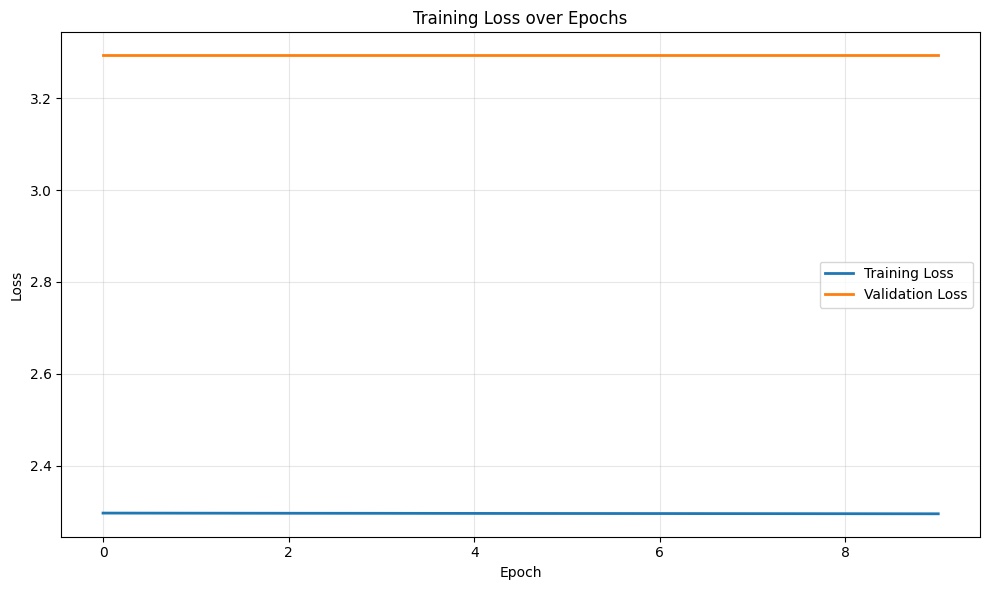

In [21]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss = evaluate_model(sim, inp, p_out, X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")

sim.close()


Evaluating on test set...


/home/z003dy4u/.local/share/virtualenvs/neuroAi--2d0xc2p/lib/python3.10/site-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
|############Constructing graph: pre-build stage (63%)           | ETA: 0:00:00
|############Constructing graph: pre-build stage (63%)           | ETA: 0:00:00
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|############# Constructing graph: build stage (21%)             | ETA: 0:00:00
|############# Constructing graph: build stage (21%)             | ETA: 0:00:00
|#######